In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

In [3]:
ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [4]:
class_names = ds.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

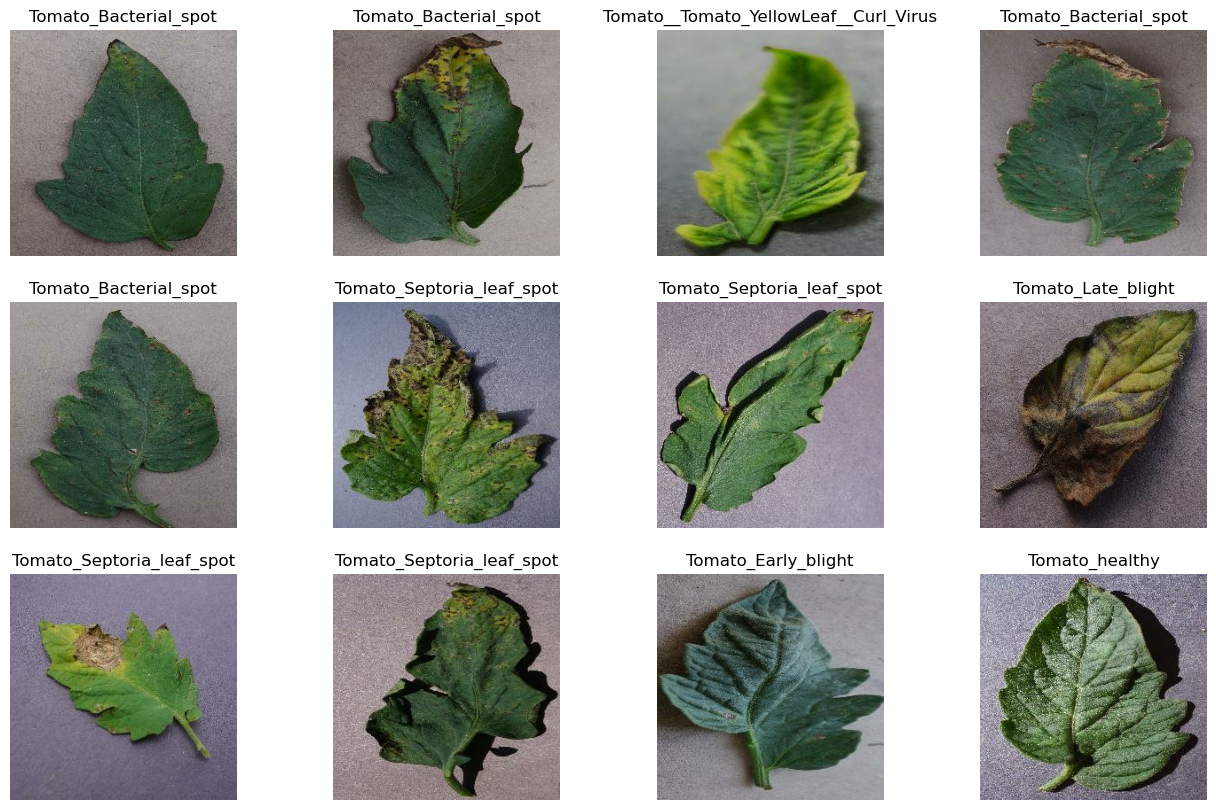

In [5]:
plt.figure(figsize=(16,10))
for image, label in ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image[i].numpy().astype(int))
        plt.title(class_names[label[i]])
        plt.axis("off")

In [6]:
train_size = 0.8
val_size = 0.1
test_size = 0.1

dataset_size = tf.data.experimental.cardinality(ds).numpy()

train_size = int(train_size * dataset_size)
val_size = int(val_size * dataset_size)

data = ds.shuffle(buffer_size=dataset_size, seed=42)

train_dataset = data.take(train_size)
val_test_dataset = data.skip(train_size)
val_dataset = val_test_dataset.take(val_size)
test_dataset = val_test_dataset.skip(val_size)

In [7]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [9]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [10]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    #layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='softmax')
])
model.build(input_shape=input_shape)

In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [13]:
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_dataset
)

Epoch 1/10


400/400 [==============================] - 438s 1s/step - loss: 1.7574 - accuracy: 0.3916 - val_loss: 1.3330 - val_accuracy: 0.5369
Epoch 2/10
400/400 [==============================] - 343s 855ms/step - loss: 1.0384 - accuracy: 0.6325 - val_loss: 0.9360 - val_accuracy: 0.6950
Epoch 3/10
400/400 [==============================] - 323s 807ms/step - loss: 0.7684 - accuracy: 0.7279 - val_loss: 0.9406 - val_accuracy: 0.6913
Epoch 4/10
400/400 [==============================] - 329s 821ms/step - loss: 0.5603 - accuracy: 0.7998 - val_loss: 1.0735 - val_accuracy: 0.6963
Epoch 5/10
400/400 [==============================] - 323s 807ms/step - loss: 0.4647 - accuracy: 0.8362 - val_loss: 0.8851 - val_accuracy: 0.7250
Epoch 6/10
400/400 [==============================] - 322s 805ms/step - loss: 0.3986 - accuracy: 0.8568 - val_loss: 0.5990 - val_accuracy: 0.8069
Epoch 7/10
400/400 [==============================] - 324s 810ms/step - loss: 0.3406 - accuracy: 0.8803 - val_loss: 0.5514 - 

In [14]:
scores = model.evaluate(test_dataset)

51/51 [==============================] - 87s 273ms/step - loss: 0.5859 - accuracy: 0.8192


In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

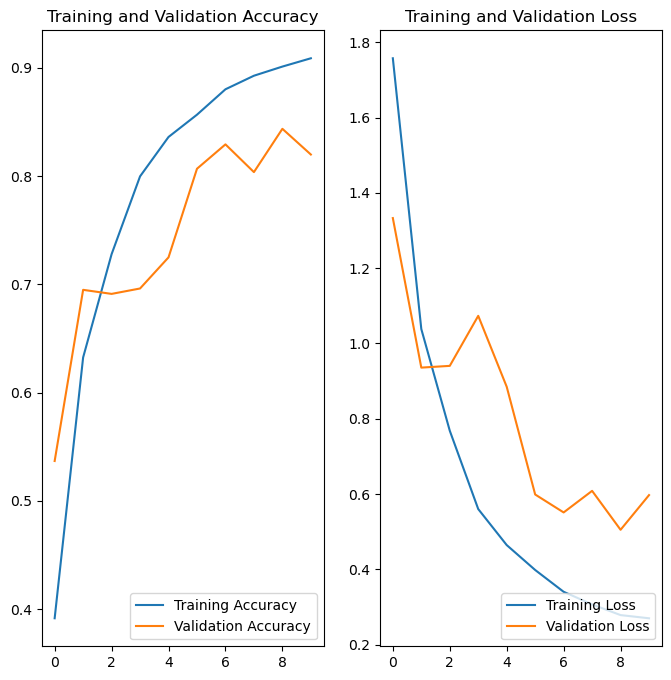

In [16]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

first image to predict
actual label: Tomato_Bacterial_spot
1/1 [==============================] - 1s 814ms/step
predicted label: Tomato_Bacterial_spot


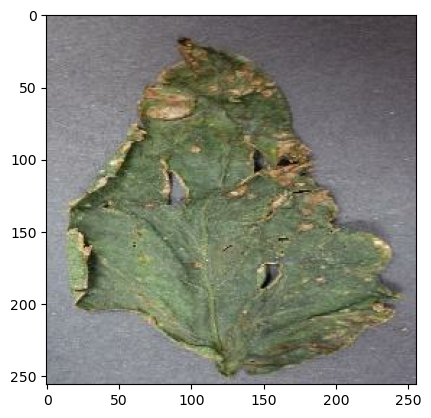

In [17]:
import numpy as np
for images_batch, labels_batch in test_dataset.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [18]:
def predicted(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 33ms/step


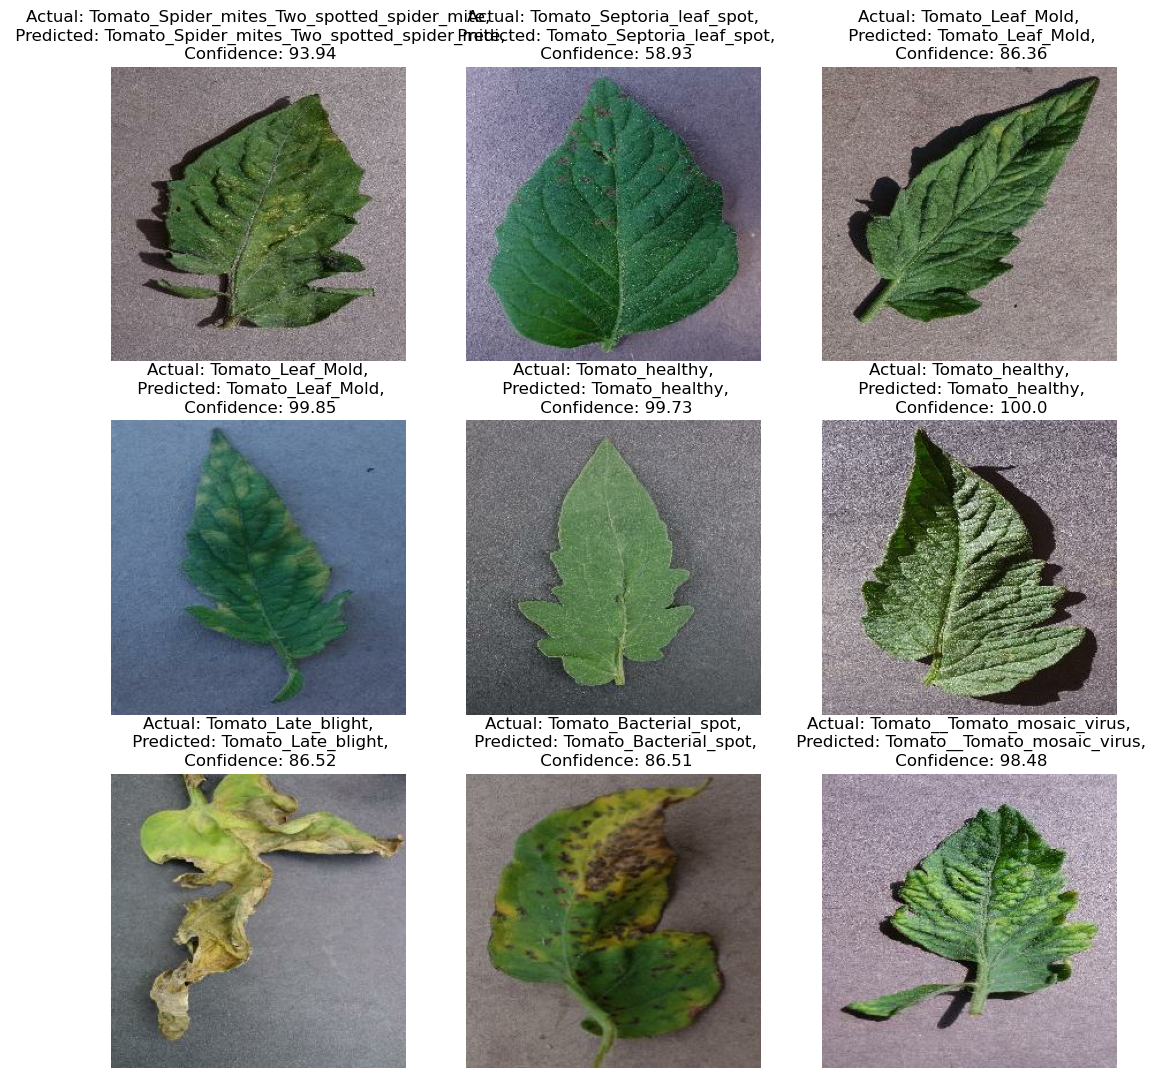

In [19]:
plt.figure(figsize=(13,13))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class,confidence = predicted(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}")
        plt.axis('off')

In [42]:
model.save("../models/model_2")

INFO:tensorflow:Assets written to: ../models/model_2\assets


INFO:tensorflow:Assets written to: ../models/model_2\assets
